In [16]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch.nn.functional as F
import optuna
import plotly
import optuna.visualization as vis
import sys
import matplotlib.pyplot as plt
import joblib


SEED = 42
np.random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
def prepare_data(file_path, batch_size=32, test_size=0.2):
    # 1) load
    df = pd.read_hdf(file_path, 'mydata')
    n_samples, T = len(df), 180

    # 2) build X,Y
    X = np.zeros((n_samples,T,2),dtype=np.float32)
    for i,row in df.iterrows():
        X[i,:,0] = np.array(row['freq'], dtype=np.float32)
        X[i,:,1] = np.array(row['m_c'],   dtype=np.float32)
    Y = df[['w_t','l_t','Q','V']].values.astype(np.float32)

    # 3) split
    Xtr, Xte, Ytr, Yte = train_test_split(
        X, Y, test_size=test_size, random_state=SEED)

    # 4) flatten & scale each channel
    sf = StandardScaler(); sm = StandardScaler(); st = StandardScaler()
    flat_tr = Xtr.reshape(-1,2); flat_te = Xte.reshape(-1,2)
    flat_tr[:,0] = sf.fit_transform(flat_tr[:,0:1]).ravel()
    flat_tr[:,1] = sm.fit_transform(flat_tr[:,1:2]).ravel()
    flat_te[:,0] = sf.transform(flat_te[:,0:1]).ravel()
    flat_te[:,1] = sm.transform(flat_te[:,1:2]).ravel()
    Xtr = flat_tr.reshape(-1,T,2)
    Xte = flat_te.reshape(-1,T,2)

    Ytr = st.fit_transform(Ytr)
    Yte = st.transform(Yte)
    
    print(f"Xtrain: {Xtr.shape} Xtest: {Xte.shape}")

    # 5) dataloaders
    tr_loader = DataLoader(
      TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(Ytr)),
      batch_size=batch_size, shuffle=True)
    te_loader = DataLoader(
      TensorDataset(torch.from_numpy(Xte), torch.from_numpy(Yte)),
      batch_size=batch_size)

    return tr_loader, te_loader, sf, sm, st

In [18]:
def get_constants(device):
    return {
        'E':            torch.tensor(169e9,   dtype=torch.float32, device=device),
        'rho':          torch.tensor(2330,    dtype=torch.float32, device=device),
        't':            torch.tensor(25e-6,   dtype=torch.float32, device=device),
        'beta':         torch.tensor(4.730041,dtype=torch.float32, device=device),
        'm_coef_b':     0.39648,
        'k_coef_b':     198.4629,
        'k_coef_b3':    12.5643,
        'electrode_length': torch.tensor(1e-3, dtype=torch.float32, device=device),
        'electrode_width':  torch.tensor(1e-3, dtype=torch.float32, device=device),
        'w_c':          torch.tensor(1e-3, dtype=torch.float32, device=device),
        'l_c':          torch.tensor(1e-3, dtype=torch.float32, device=device),
        'd':            torch.tensor(1e-6, dtype=torch.float32, device=device),
        'Vac_ground':   torch.tensor(1e-3, dtype=torch.float32, device=device),
        'phi':          torch.linspace(
                             math.pi/10,
                             math.pi/10 + math.pi/160,
                             180, device=device)
    }


In [19]:
def build_model(hidden_dim, T=180):
    # LAME FIKS A BETTER MODEL ==> NOW COLLAPSES WHOLE TIME SERIES INTO LONG Feature vector SAMPLE ( VIA FLATTEN) ==> other ideas time dependent (1D Convolutional Layers, Recurrent Layers (LSTM/GRU), (Transformer / Attention))
    class PINN_MultiHead(nn.Module):
        def __init__(self):
            super().__init__()
            self.trunk = nn.Sequential(nn.Flatten(),
                nn.Linear(2*T, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim//2), nn.ReLU(),
                nn.Linear(hidden_dim//2, hidden_dim//4), nn.ReLU()
            )
            self.heads = nn.ModuleList([
                nn.Linear(hidden_dim//4,1) for _ in range(4)
            ])
            self.log_var_data = nn.Parameter(torch.zeros(1))
            self.log_var_phys = nn.Parameter(torch.zeros(1))

            # Learnable loss weigths

        def forward(self,x):
            z = self.trunk(x)
            return torch.cat([h(z) for h in self.heads], dim=1)

    return PINN_MultiHead().to(device)

In [20]:
def make_optimizer(model, lr, weight_decay): # make factor hyperparameter
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    sched = optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode = 'min', factor=0.5, patience=10)
    return opt, sched

In [21]:

def calculate_params_vectorized(w_n, l_n, Q_n, V_n, consts, norm_sfs):
   
    # Unpack the target scaler
    _, _, st = norm_sfs
    
    # Denormalize outputs
    out_mean = torch.tensor(st.mean_, device=w_n.device, dtype=torch.float32)
    out_std  = torch.tensor(st.scale_, device=w_n.device, dtype=torch.float32)
   
    w = w_n * out_std[0] + out_mean[0]
    l = l_n * out_std[1] + out_mean[1] 
    Q = Q_n * out_std[2] + out_mean[2]
    V = V_n * out_std[3] + out_mean[3]
    
    eps = 1e-9
    # Beam stiffness and mass
    k_t  = (consts['k_coef_b'] / 12) * consts['E'] * consts['t'] * (w / (l + eps))**3
    k_t3 =  consts['k_coef_b3'] * consts['E'] * consts['t'] * (w / (l + eps)**3)
    Mass = consts['rho'] * (
        consts['t'] * w * l * consts['m_coef_b']
        + consts['electrode_length'] * consts['electrode_width'] * consts['t']
        + 2 * consts['w_c'] * consts['l_c'] * consts['t']
    )

    # Transduction factors
    trans = 8.85e-12 * V * consts['electrode_length'] * consts['t'] / (consts['d']**2)
    k_e  = 2 * trans * V / consts['d']
    k_e3 = 4 * trans * V / (consts['d']**3)
    fac  = consts['Vac_ground'] * trans
    c    = torch.sqrt(Mass * k_t) / Q

    return {
        'k_t':   k_t,
        'k_t3':  k_t3,
        'Mass':  Mass,
        'k_e':   k_e,
        'k_e3':  k_e3,
        'fac':   fac,
        'c':     c,
        'trans': trans,
        'phi':   consts['phi']  # shape (T,)
    }



## view data 

In [22]:
import pandas as pd
import numpy as np

def view_h5_dataset(file_path, group_key='mydata', n_show=3, show_stats=True):
    """
    查看 .h5 文件内容，适配你的数据格式
    file_path: str, .h5 文件路径
    group_key: str, 数据集名称（默认'mydata'，如 prepare_data 所用）
    n_show: int, 显示前n条详细内容
    show_stats: bool, 是否输出基础统计
    """
    print(f"读取文件: {file_path}")
    df = pd.read_hdf(file_path, group_key)
    print("="*50)
    print(f"数据集行数: {len(df)}")
    print(f"列名: {list(df.columns)}")
    print("="*50)
    # 显示前几行
    print("前几行数据：")
    print(df.head(n_show))
    print("="*50)
    # 检查每列的shape/类型
    for col in df.columns:
        v = df.iloc[0][col]
        print(f"列: {col:10s} 类型: {type(v)}", end='')
        if isinstance(v, (np.ndarray, list)):
            print(f" shape: {np.array(v).shape}")
        else:
            print(f" value: {v}")
    print("="*50)
    if show_stats:
        # 只显示数值型统计
        num_df = df.select_dtypes(include=[np.number])
        if not num_df.empty:
            print("数值特征统计：")
            print(num_df.describe().T)
        else:
            print("没有数值型直接特征。")
    # 检查nan
    print("="*50)
    print("每列缺失值数量：")
    print(df.isnull().sum())
    print("="*50)
    # 检查数组型数据维度
    arr_cols = [c for c in df.columns if isinstance(df.iloc[0][c], (np.ndarray, list))]
    if arr_cols:
        for c in arr_cols:
            shapes = [np.array(x).shape for x in df[c][:min(len(df), 10)]]
            print(f"列 {c} 前10项 shape: {shapes}")
    return df


In [23]:
# 假设你的文件叫 'pinns_1.h5'
df = view_h5_dataset('pinns_1.h5')


读取文件: pinns_1.h5
数据集行数: 43263
列名: ['w_t', 'l_t', 'electrode_length', 'electrode_width', 'w_c', 'l_c', 'Q', 'V', 'd', 'Vac_ground', 'freq', 'm_c']
前几行数据：
        w_t     l_t  electrode_length  electrode_width      w_c      l_c  \
0  0.000005  0.0001            0.0007          0.00002  0.00001  0.00002   
1  0.000005  0.0001            0.0007          0.00002  0.00001  0.00002   
2  0.000005  0.0001            0.0007          0.00002  0.00001  0.00002   

       Q  V         d  Vac_ground  \
0   5000  1  0.000002       0.005   
1   7500  1  0.000002       0.005   
2  10000  1  0.000002       0.005   

                                                freq  \
0  [509790.918044993, 509815.15179048723, 509835....   
1  [509887.2996163992, 509903.45838261885, 509917...   
2  [509935.497248505, 509947.6174210848, 509957.9...   

                                                 m_c  
0  [0.0023880162111822277, 0.002598999202110579, ...  
1  [0.0035820243167734877, 0.0038984988031658414,...  
2  

## elias physics_loss function

In [7]:
def physics_loss_with_nan_penalty(freq_res, disp_res, penalty=1.0):
    """
    freq_res, disp_res: (B, T) residuals
    penalty: weight on the fraction of invalid timesteps per sample
    """
    # 1) mask of valid timesteps
    valid = torch.isfinite(freq_res) & torch.isfinite(disp_res)       # (B, T)

    # 2) zero out invalid values
    f = torch.where(valid, freq_res, torch.zeros_like(freq_res))
    d = torch.where(valid, disp_res, torch.zeros_like(disp_res))

    # 3) squared residuals
    sq     = f.pow(2) + d.pow(2)                                      # (B, T)
    sum_sq = sq.sum(dim=1)                                            # (B,)

    # 4) count valids
    n_valid   = valid.sum(dim=1).float()                              # (B,)
    T         = freq_res.size(1)                                      # scalar
    n_invalid = T - n_valid                                           # (B,)

    # 5) average over **valid** points + penalty on invalid fraction
    avg_valid      = sum_sq / torch.clamp(n_valid, min=1.0)           # (B,)
    frac_invalid   = n_invalid / T                                    # (B,)
    loss_per_sample = avg_valid + penalty * frac_invalid             # (B,)

    # 6) return batch mean
    return loss_per_sample.mean()


In [63]:
def physics_informed_loss_norm(pred, Xb, consts, norm_sfs, denom_clamp, physics_clamp):

    sf, sm, st = norm_sfs
    freq  = Xb[:,:,0] * sf.scale_[0] + sf.mean_[0]
    mc    = Xb[:,:,1] * sm.scale_[0] + sm.mean_[0]
    omega = freq * (2 * math.pi)

    # Denormalize outputs per sample 
    w_n, l_n, Q_n, V_n = pred[:,0], pred[:,1], pred[:,2], pred[:,3]
    p = calculate_params_vectorized(w_n, l_n, Q_n, V_n, consts, norm_sfs)

    # y: displacement,
    denom = (omega * p['trans'].unsqueeze(1)).clamp(min=denom_clamp)
    y = (mc*1e-9) / denom

    kt,ke,kt3,ke3,mass,c,fac=p['k_t'],p['k_e'],p['k_t3'],p['k_e3'],p['Mass'],p['c'],p['fac']
    kt,ke,kt3,ke3,mass,c,fac=[t.unsqueeze(1) for t in (kt,ke,kt3,ke3,mass,c,fac)]
    phi=p['phi'].unsqueeze(0)

    # Residuals 
    freq_res = c * omega * y - fac * torch.sin(phi)
    disp_res = -mass * omega**2 * y \
               + (kt - ke) * y \
               + 0.75 * (kt3 - ke3) * (y**3) \
               - fac * torch.cos(phi)
    
    # freq_res = torch.nan_to_num(freq_res, nan=1e-4, posinf=1e-4, neginf=-1e-4)
    # disp_res = torch.nan_to_num(disp_res, nan=1e-4, posinf=1e-4, neginf=-1e-4)
    # step_loss = freq_res.pow(2) + disp_res.pow(2)
    # step_loss = step_loss.clamp(max=1e-4)

    loss = (freq_res.pow(2) + disp_res.pow(2)).clamp(max=physics_clamp) #

    return loss.mean()

In [ ]:
def combined_loss_norm(model, out, Xb, Yb, constants, norm_p,count, countmax, denom_clamp, physics_clamp, log_clamp, weighted):
    # physics‐informed term (finite by construction)
    #L_phys = physics_informed_loss_norm(out, Xb, constants, norm_p, denom_clamp, physics_clamp)
    L_phys = physics_informed_loss_norm(out, Xb, constants, norm_p, denom_clamp, physics_clamp)
    if torch.isnan(L_phys):
        count += 1
        L_phys = 1e-3
    # clamp large physics loss
    if L_phys > physics_clamp: # fiks later
        countmax += 1
        if isinstance(L_phys, torch.Tensor):
            L_phys = L_phys.clamp(max=physics_clamp)
        else:
            L_phys = float(physics_clamp)
        
    # data term
    L_data = nn.MSELoss()(out, Yb)
    L_balanced = L_phys + L_data

    # Weighted loss calculation
    log_d = model.log_var_data.clamp(-log_clamp, log_clamp)
    log_p = model.log_var_phys.clamp(-log_clamp, log_clamp)

    w_term = torch.exp(-log_d) * L_data + log_d
    p_term = torch.exp(-log_p) * L_phys + log_p
    L_weighted = (w_term + p_term)

    if weighted == True:
        loss = L_weighted
    else:
        loss = L_balanced

    return count, loss, countmax, L_phys, L_data

In [66]:
def train_one_epoch(model, loader, optimizer, constants, norm_sfs, denom_clamp, physics_clamp, log_clamp, weighted):
    model.train()
    total_loss = 0.0
    skip_cnt, max_cnt = 0, 0
    for Xb, Yb in loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()

        skip_cnt, loss, max_cnt, L_phys, L_data= combined_loss_norm(model, model(Xb), Xb, Yb, constants, norm_sfs, skip_cnt, max_cnt, denom_clamp, physics_clamp, log_clamp, weighted)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    n_updates = len(loader) 
    avg_loss = total_loss / n_updates if n_updates > 0 else float('inf')
    return avg_loss, skip_cnt, max_cnt


In [67]:
def validate_one_epoch(model, loader, constants, norm_sfs, denom_clamp, physics_clamp, log_clamp, weighted):
    model.eval()
    skip_cnt, max_cnt = 0, 0
    total_loss = 0.0
    epoch_loss = float('inf')

    with torch.no_grad():
        for Xb, Yb in loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            skip_cnt, loss, max_cnt, L_phys, L_data= combined_loss_norm(model, model(Xb), Xb, Yb, constants, norm_sfs, skip_cnt, max_cnt, denom_clamp, physics_clamp, log_clamp, weighted)
            total_loss += loss.item()

        if skip_cnt < len(loader):
            epoch_loss = total_loss / len(loader)

    return epoch_loss, skip_cnt, max_cnt

In [68]:


def plot_training_history(history):
 
    epochs = range(1, len(history['train_losses']) + 1)

    def _plot(title, ylabel, *series):
        plt.figure(figsize=(8,4))
        for name, vals in series:
            plt.plot(epochs, vals, label=name)
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.show()

    # Combined loss
    _plot('Combined Loss over Epochs', 'Loss',
          ('Train', history['train_losses']),
          ('Test',  history['test_losses']))
    # Skips
    _plot('Skipped Samples per Epoch', 'Count',
          ('Train Skips', history['train_skips']),
          ('Test Skips',  history['test_skips']))
    # MAE, MSE, R²
    _plot('MAE over Epochs', 'MAE',
          ('Train MAE', history['train_mae']),
          ('Test MAE',  history['test_mae']))
    _plot('MSE over Epochs', 'MSE',
          ('Train MSE', history['train_mse']),
          ('Test MSE',  history['test_mse']))
    _plot('R² over Epochs', 'R² Score',
          ('Train R2', history['train_r2']),
          ('Test R2',  history['test_r2']))


In [69]:
# === Basic run with known safe values ===
def main_default(file_path, constants,
                 lr=1e-3, weight_decay=1e-5,
                 hidden_dim=256,
                 physics_clamp=1e-3, denom_clamp=1e-4,
                 log_clamp=5.0, epochs=500, patience = 15,
                 stop_crit=1e-4, weighted=False):
    

    tr_loader, te_loader, sf, sm, st = prepare_data(file_path)
    
    X_tr_full = tr_loader.dataset.tensors[0].to(device)           
    Y_tr_full = tr_loader.dataset.tensors[1].to(device)
    X_te_full = te_loader.dataset.tensors[0].to(device)
    Y_te_full = te_loader.dataset.tensors[1].to(device)

    # Build model
    model = build_model(hidden_dim, T=180).to(device)
    optimizer, scheduler = make_optimizer(model, lr, weight_decay)

    train_losses, test_losses = [], []
    train_skips,  test_skips  = [], []

    train_mae, test_mae = [], []
    train_mse, test_mse = [], []
    train_r2,  test_r2  = [], []

    # Train/test
    best_val = float("inf")

    for epoch in range(epochs):
        tr_loss, tr_skips, _ = train_one_epoch(model, tr_loader, optimizer, constants, (sf,sm,st), denom_clamp, physics_clamp, log_clamp, weighted)
        val_loss, val_skips, _ = validate_one_epoch(model, te_loader, constants,(sf,sm,st), denom_clamp, physics_clamp, log_clamp, weighted)
        scheduler.step(val_loss)

        train_losses.append(tr_loss)
        test_losses.append(val_loss)
        train_skips.append(tr_skips)
        test_skips.append(val_skips)

        model.eval()
        with torch.no_grad():
            y_tr_pred_raw = model(X_tr_full).cpu().numpy()
            y_te_pred_raw = model(X_te_full).cpu().numpy()

        y_tr_true_raw = Y_tr_full.cpu().numpy()
        y_te_true_raw = Y_te_full.cpu().numpy()

        # inverse‐scale
        y_tr_true = st.inverse_transform(y_tr_true_raw)
        y_te_true = st.inverse_transform(y_te_true_raw)
        y_tr_pred = st.inverse_transform(y_tr_pred_raw)
        y_te_pred = st.inverse_transform(y_te_pred_raw)

        # ——— New: mask out any rows with NaNs ———
    
        mask_tr = ~(
            np.isnan(y_tr_true).any(axis=1) |
            np.isnan(y_tr_pred).any(axis=1)
        )
        mask_te = ~(
            np.isnan(y_te_true).any(axis=1) |
            np.isnan(y_te_pred).any(axis=1)
        )
        kept_tr = mask_tr.sum()
        kept_te = mask_te.sum()
        print(f"  -> keeping {kept_tr}/{len(mask_tr)} train samples, "f"{kept_te}/{len(mask_te)} test samples")

        y_tr_t = y_tr_true[mask_tr]
        y_tr_p = y_tr_pred[mask_tr]
        y_te_t = y_te_true[mask_te]
        y_te_p = y_te_pred[mask_te]

        # ——— Now safe to compute metrics ———
        if len(y_tr_t) == 0 or len(y_te_t) == 0:
            print(f"ALERT Epoch {epoch}: all samples masked → recording NaN metrics")
            train_mae.append(np.nan)
            train_mse.append(np.nan)
            train_r2.append(np.nan)
            test_mae.append(np.nan)
            test_mse.append(np.nan)
            test_r2.append(np.nan)
        else:
            train_mae.append(mean_absolute_error(y_tr_t, y_tr_p))
            train_mse.append(mean_squared_error(y_tr_t, y_tr_p))
            train_r2.append(r2_score(y_tr_t, y_tr_p))

            test_mae.append(mean_absolute_error(y_te_t, y_te_p))
            test_mse.append(mean_squared_error(y_te_t, y_te_p))
            test_r2.append(r2_score(y_te_t, y_te_p))
            
        print(f"Epoch {epoch}/{epochs} | Train {tr_loss:.4f} (skips {tr_skips}) | "f"Val {val_loss:.4f} (skips {val_skips}) | "f"MAE {train_mae[-1]:.4f}/{test_mae[-1]:.4f} | "f" R^2 {train_r2[-1]:.4f}/{test_r2[-1]:.4f} ")

        no_improvement = 0
        if val_loss < best_val - stop_crit:
            best_val, no_improvement = val_loss, 0
            torch.save(model.state_dict(), 'best.pth')
        else:
            no_improvement += 1
        if no_improvement > patience:
            print("Early stopping."); break
    
    history = {
      'train_losses': train_losses,
      'test_losses':  test_losses,
      'train_skips':  train_skips,
      'test_skips':   test_skips,
      'train_mae':    train_mae,
      'test_mae':     test_mae,
      'train_mse':    train_mse,
      'test_mse':     test_mse,
      'train_r2':     train_r2,
      'test_r2':      test_r2,
    }

    return history

In [70]:
import optuna

def objective(trial):
    constants = get_constants(device) 

    lr              = trial.suggest_float('lr', 1e-6, 1e-3, log = True)
    weight_decay    = trial.suggest_float('weight_decay', 1e-6, 1e-1, log = True)
    hidden_dim      = trial.suggest_categorical('hidden_dim', [128, 256, 512, 1024])
    weighted        = trial.suggest_categorical('weighted', [False, True])
    physics_clamp   = trial.suggest_float('physics_clamp', 1e-6, 1e-1, log = True)
    denom_clamp     = trial.suggest_float('denom_clamp', 1e-9, 1e-2, log = True)
    log_clamp       = trial.suggest_float('log_clamp', 1e-2, 1e2, log = True)
    stop_crit       = trial.suggest_float('stop_crit', 1e-9, 1e-3, log = True)
    patience        = trial.suggest_int('patience', 5, 30)


    # 2) run one full train/val with those settings
    history = main_default(
        file_path='pinns_1.h5',
        constants= constants,
        lr=lr,
        weight_decay=weight_decay,
        hidden_dim=hidden_dim,
        physics_clamp=physics_clamp,      # you could also trial-tune these
        denom_clamp=denom_clamp,
        log_clamp=log_clamp,
        epochs=200,
        patience=patience,
        stop_crit=stop_crit,
        weighted=weighted
    )

    # 3) return final validation loss to minimize
    return history['test_losses'][-1]

# Create and run the study
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=600)
#
#print("Best hyperparameters:", study.best_params)
#print("Best validation loss:", study.best_value)
#import optuna.visualization as vis
#fig = vis.plot_optimization_history(study)
#fig.show()


In [71]:

#print("Best hyperparameters:", study.best_params)
#print("Best validation loss:", study.best_value)
#import optuna.visualization as vis
#fig = vis.plot_optimization_history(study)
#fig.show()


Xtrain: (34610, 180, 2) Xtest: (8653, 180, 2)
  -> keeping 34610/34610 train samples, 8653/8653 test samples
Epoch 0/500 | Train 0.5595 (skips 102) | Val 0.5188 (skips 6) | MAE 2393.6526/2396.9211 |  R^2 0.4869/0.4811 
  -> keeping 34610/34610 train samples, 8653/8653 test samples
Epoch 1/500 | Train 0.5068 (skips 43) | Val 0.5034 (skips 12) | MAE 2357.4888/2363.2676 |  R^2 0.5027/0.4965 
  -> keeping 34610/34610 train samples, 8653/8653 test samples
Epoch 2/500 | Train 0.4940 (skips 26) | Val 0.4929 (skips 0) | MAE 2322.0522/2327.7263 |  R^2 0.5148/0.5070 
  -> keeping 34610/34610 train samples, 8653/8653 test samples
Epoch 3/500 | Train 0.4871 (skips 16) | Val 0.5048 (skips 49) | MAE 2319.6069/2323.1299 |  R^2 0.5030/0.4950 
  -> keeping 34610/34610 train samples, 8653/8653 test samples
Epoch 4/500 | Train 0.4827 (skips 21) | Val 0.4798 (skips 0) | MAE 2309.6750/2308.8772 |  R^2 0.5270/0.5201 
  -> keeping 34610/34610 train samples, 8653/8653 test samples
Epoch 5/500 | Train 0.4772 (

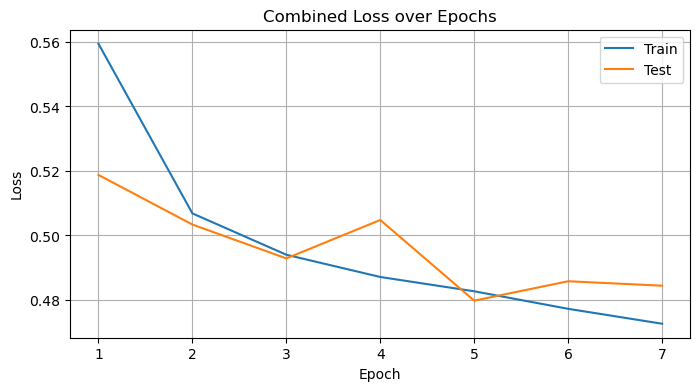

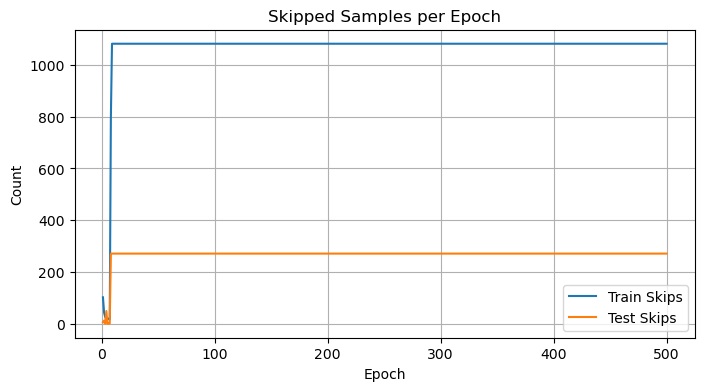

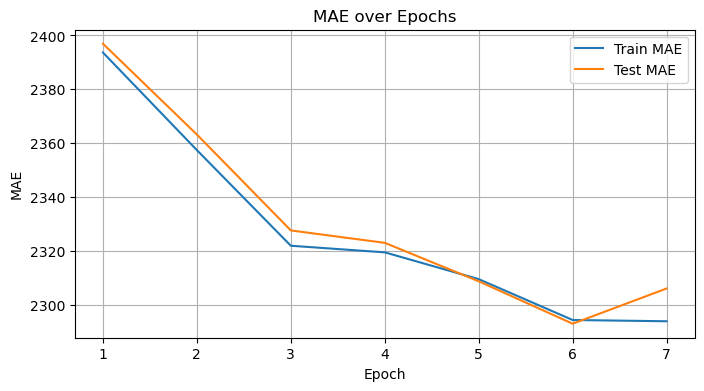

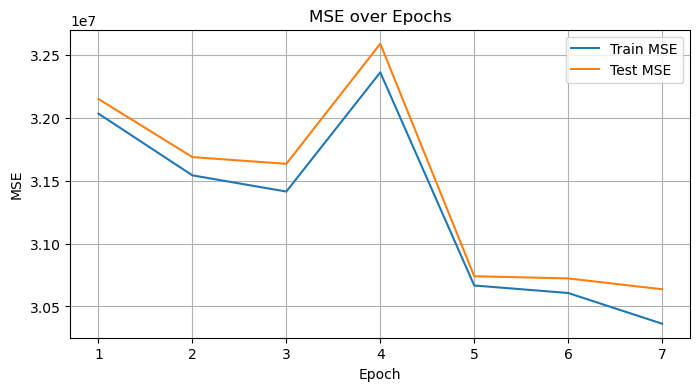

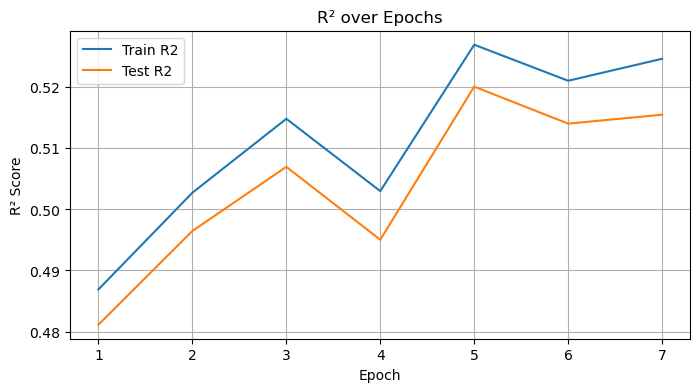

Keys in history: ['train_losses', 'test_losses', 'train_skips', 'test_skips', 'train_mae', 'test_mae', 'train_mse', 'test_mse', 'train_r2', 'test_r2']
First 5 train losses: [0.5594717972324869, 0.5068276274446639, 0.49399934315196686, 0.4870996516810768, 0.48266129173655165]
First 5 val   losses: [0.5187675425047364, 0.5033672394787694, 0.4928669500614884, 0.5047802310368231, 0.4797602790748061]


In [72]:
constants = get_constants(device)  
history = main_default('pinns_1.h5', constants)
plot_training_history(history)
# 5) sanity‐check the returned history dict
print("Keys in history:", list(history.keys()))
print("First 5 train losses:", history['train_losses'][:5])
print("First 5 val   losses:", history['test_losses'][:5])

In [73]:
def main(file_path, constants,
         num_epochs=100,
         lr=1e-4, weight_decay=1e-5,
         physics_clamp=1e-3, denom_eps=1e-9, penalty=1.0):
    tr_loader, te_loader, sf, sm, st = prepare_data(file_path,batch_size=32, test_size=0.2)
    norm_p = (sf, sm, st)

    model = build_model().to(device)
    optimizer, scheduler = make_optimizer(model, lr, weight_decay)

    history = {'train_loss': [], 'val_loss': []}

    best_val, patience = float('inf'), 0
    for epoch in range(1, num_epochs+1):
        tr = train_one_epoch(model, tr_loader, optimizer, constants, norm_p,
                             physics_clamp=physics_clamp,
                             denom_eps=denom_eps,
                             penalty=penalty)
        va = validate_one_epoch(model, te_loader, constants, norm_p,
                                physics_clamp=physics_clamp,
                                denom_eps=denom_eps,
                                penalty=penalty)
        scheduler.step(va)

        history['train_loss'].append(tr)
        history['val_loss'].append(va)
        print(f"Epoch {epoch:3d} | Train {tr:.4f} | Val {va:.4f}")

        if va < best_val - 1e-4:
            best_val, patience = va, 0
            torch.save(model.state_dict(), 'best.pth')
        else:
            patience += 1
            if patience > 10:
                print("Early stopping")
                break

    return history


In [74]:
#history = main(
#   'pinns_1.h5', constants,
#   lr=trial.suggest_loguniform('lr', 1e-5, 1e-3),
#   weight_decay=trial.suggest_loguniform('wd', 1e-6, 1e-2),
#   physics_clamp=trial.suggest_loguniform('pc',1e-6,1e-2),
#   denom_eps=trial.suggest_loguniform('de',1e-9,1e-6),
#   penalty=trial.suggest_float('pen', 0.1,10.0)
#)
#return history['val_loss'][-1]

In [75]:


#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=1800, show_progress_bar=True)


In [76]:
#print("Best hyperparameters:")
#print(study.best_trial.params)
#
## Optional: Save study
#import joblib
#joblib.dump(study, 'optuna_study.pkl')

In [77]:

#
## Visualize the optimization history (show how the objective function value changed)
#vis.plot_optimization_history(study)
#
## Visualize the hyperparameter importance (which parameters were most important in the optimization process)
#vis.plot_param_importances(study)
#
## Visualize the relationship between hyperparameters and the objective function
#vis.plot_parallel_coordinate(study)
#
## Visualize the hyperparameter search space as a contour plot
#vis.plot_slice(study)


In [78]:
#param_grid = [
#    {'T': 180, 'hidden_dim': 128, 'lr': 1e-4, 'max_epochs': 10, 'early_stop_patience': 20},
#]
#
#best_config = hyperparam_search('pinns_1.h5', constants, param_grid)
#print("Best config found:", best_config)
#